**Team 08**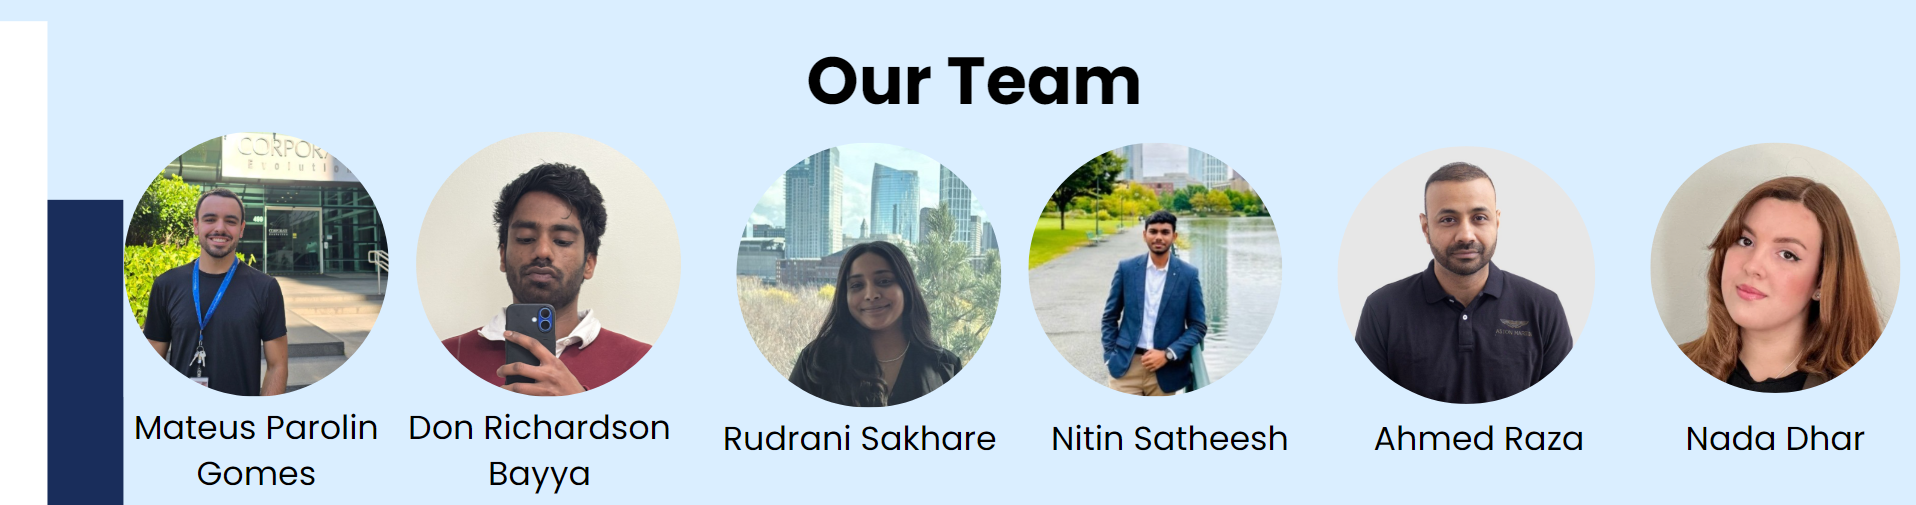

# **SEOUL BIKE DATASET**

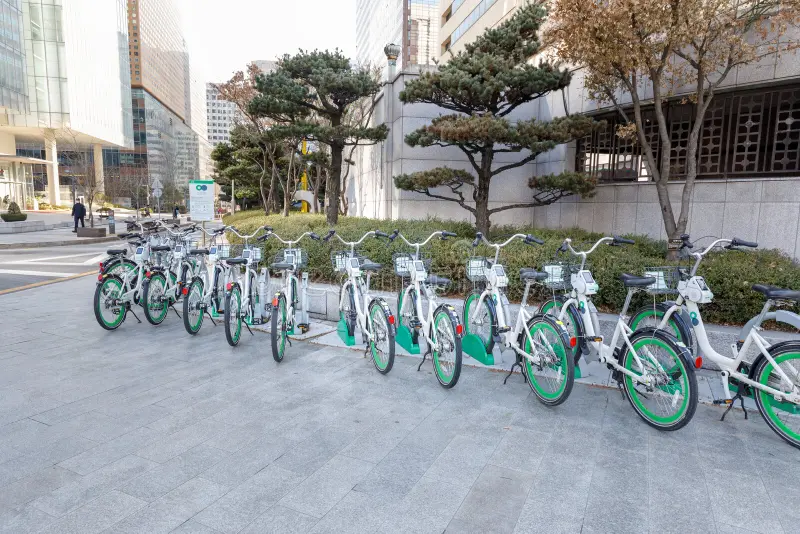

This analysis aims to examine patterns in daily bike rental activity for the Seoul Bike Sharing Service and develop a predictive framework for classifying demand levels. By leveraging historical data that includes weather conditions, seasonal factors, and operational indicators, the objective is to identify the key factors influencing usage and support data-driven decision-making. The insights derived from this study are intended to enhance planning, improve resource allocation, and support strategic initiatives for optimizing service delivery.

In [ ]:
import pandas as pd # For Data manipulation
import numpy as np # Numerical computations
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns # Statistical plotting
from sklearn.model_selection import train_test_split # Split data sets
from sklearn.preprocessing import StandardScaler # Feature scaling tool
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Model evaluation metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Decision tree model
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier # Ensemble learning models
from xgboost import XGBClassifier # Extreme gradient boosting
from sklearn.model_selection import GridSearchCV # # Hyperparameter tuning tool
from sklearn.tree import DecisionTreeClassifier # Decision tree classifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Step 2: Load Dataset
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Step 3: Clean Column Names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("(", "").str.replace(")", "")

# Step 4: Create Target Variable
# We'll classify whether demand is high or low based on the median of 'Rented_Bike_Count'
median_bike_count = df['Rented_Bike_Count'].median()
df['High_Demand'] = np.where(df['Rented_Bike_Count'] >= median_bike_count, 1, 0)


# **Exploratory Data Analysis**


In [ ]:
#Check how the data looks
print("Shape:", df.shape)
print("Sample rows:\n", df.head())
print("Class distribution:\n", df['High_Demand'].value_counts())

Shape: (8760, 15)
Sample rows:
          Date  Rented_Bike_Count  Hour  Temperature°C  Humidity%  \
0  01/12/2017                254     0           -5.2         37   
1  01/12/2017                204     1           -5.5         38   
2  01/12/2017                173     2           -6.0         39   
3  01/12/2017                107     3           -6.2         40   
4  01/12/2017                 78     4           -6.0         36   

   Wind_speed_m/s  Visibility_10m  Dew_point_temperature°C  \
0             2.2            2000                    -17.6   
1             0.8            2000                    -17.6   
2             1.0            2000                    -17.7   
3             0.9            2000                    -17.6   
4             2.3            2000                    -18.6   

   Solar_Radiation_MJ/m2  Rainfallmm  Snowfall_cm Seasons     Holiday  \
0                    0.0         0.0          0.0  Winter  No Holiday   
1                    0.0         0.0    

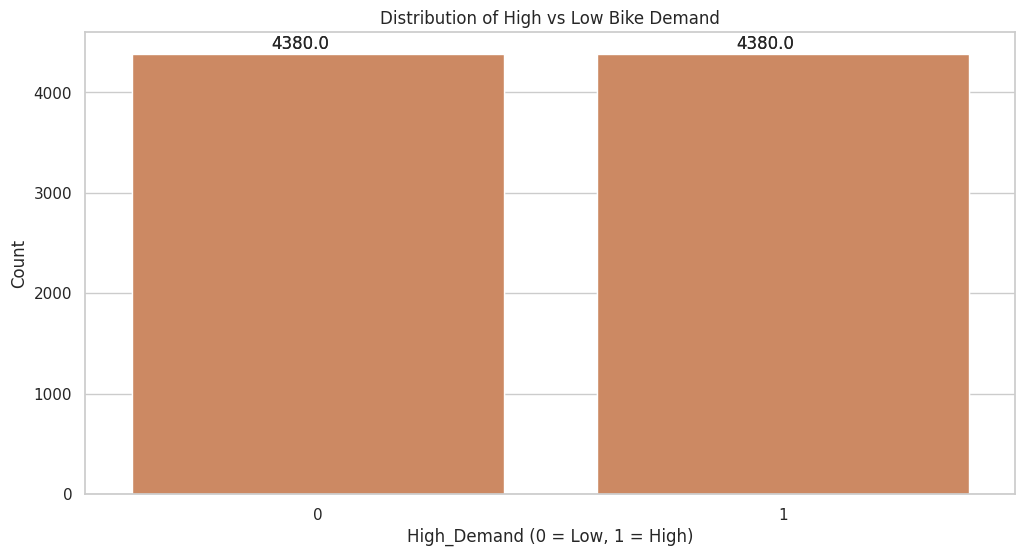

In [ ]:
# Set visual style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))


# 1. Target Variable Distribution
sns.countplot(x='High_Demand', data=df)
plt.title('Distribution of High vs Low Bike Demand')
plt.xlabel('High_Demand (0 = Low, 1 = High)')
plt.ylabel('Count')
ax = sns.countplot(x='High_Demand', data=df)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.3, p.get_height()+50))

plt.show()

**Distribution of Target Variable:**

The distribution of bike demand categorized into High (1) and Low (0). Both categories have equal observations of 4380 each, indicating a perfectly **balanced dataset**. This is useful for classification models because balanced classes prevent bias toward any specific category, ensuring better model accuracy and performance during prediction.

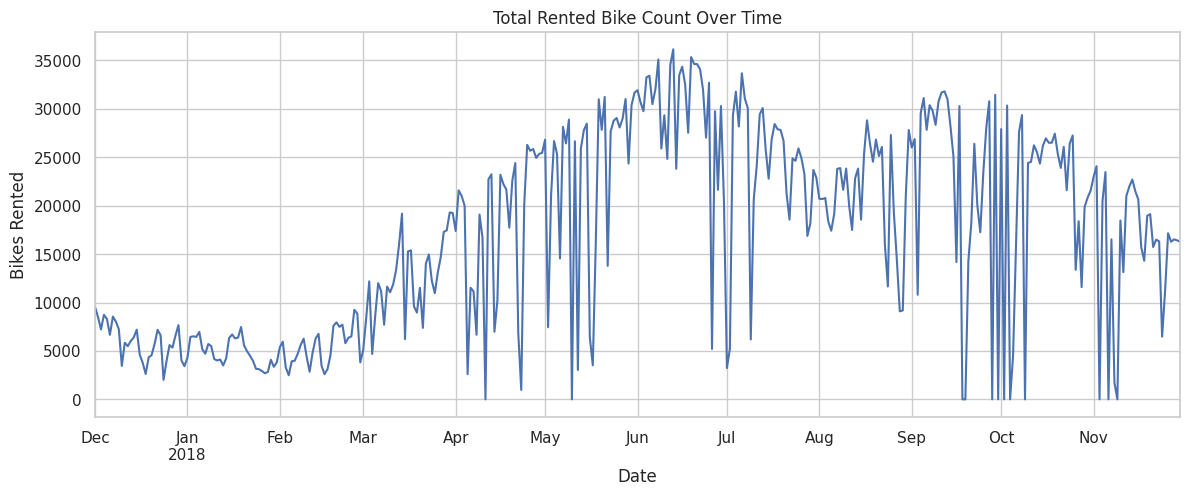

In [ ]:
# 2.Rentals Over Time

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Time-series plot of bike rentals
daily_counts = df.groupby('Date')['Rented_Bike_Count'].sum()

plt.figure(figsize=(14, 5))
daily_counts.plot()
plt.title('Total Rented Bike Count Over Time')
plt.xlabel('Date')
plt.ylabel('Bikes Rented')
plt.grid(True)
plt.show()


**Rental Bike Demand Over Time**

This time-series line plot visualizes the total rented bike count over time. The x-axis shows the date, and the y-axis shows the number of bikes rented. The trend indicates that bike rentals increased from early 2018, peaked during the summer months (May to July), and then gradually declined towards the end of the year. This highlights seasonal demand patterns in bike rentals.

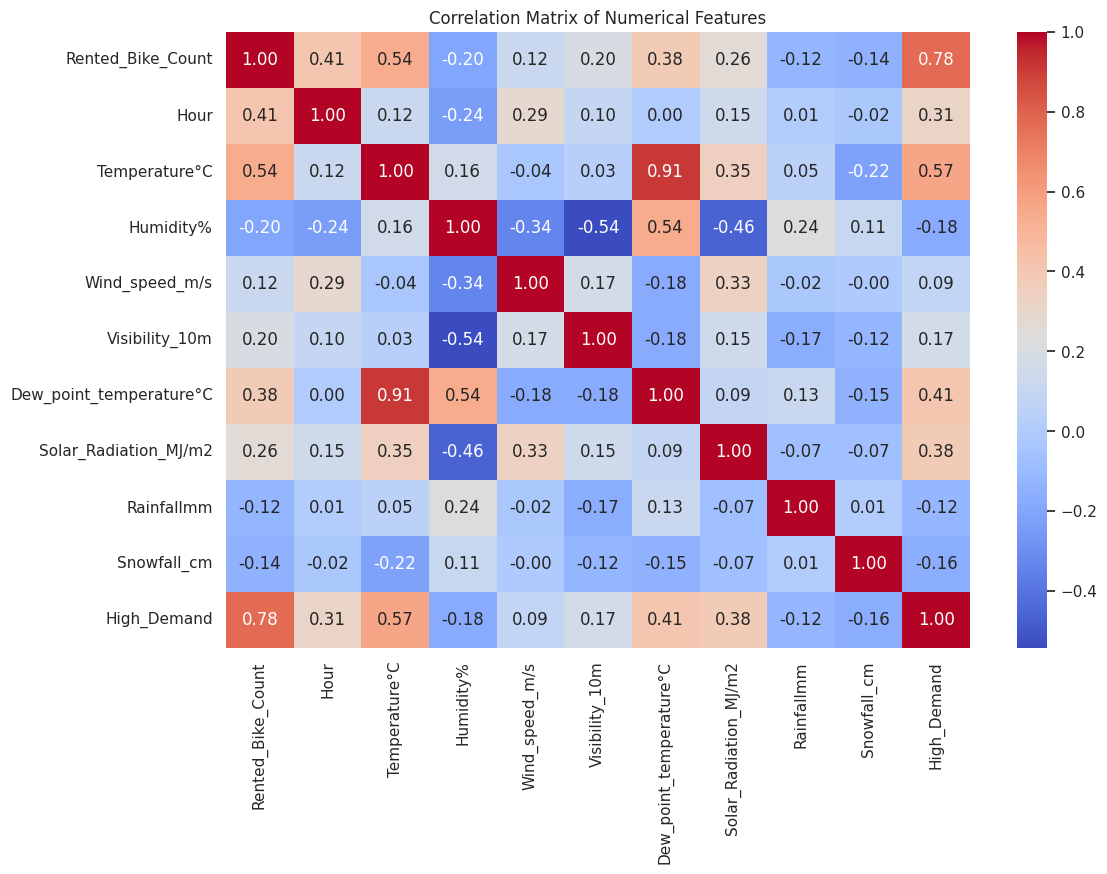

In [ ]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


**Correlation Matrix for Numerical Features**

The correlation heatmap showing the relationship between numerical features in the dataset.

* Rented_Bike_Count is highly positively correlated with High_Demand (0.78) and Temperature (0.54).

* Humidity has a negative correlation (-0.20) with Rented_Bike_Count, meaning higher humidity reduces bike rentals.

* Hour (0.41) and Solar_Radiation (0.26) moderately affect rentals.

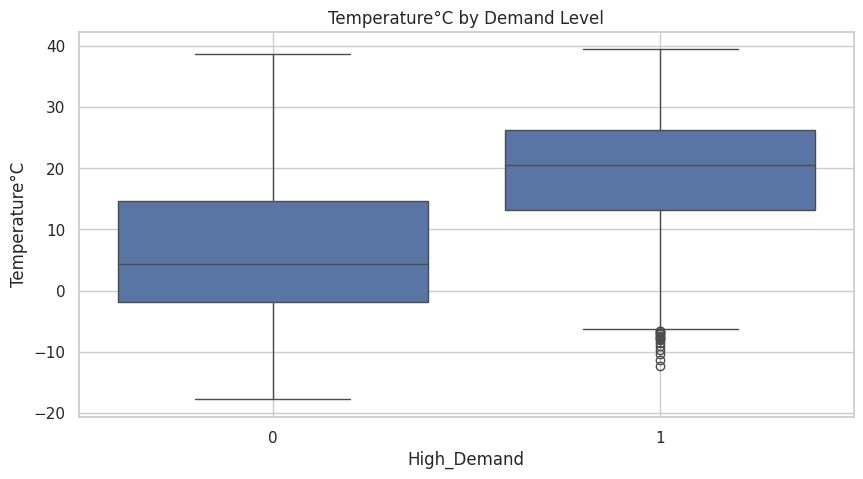

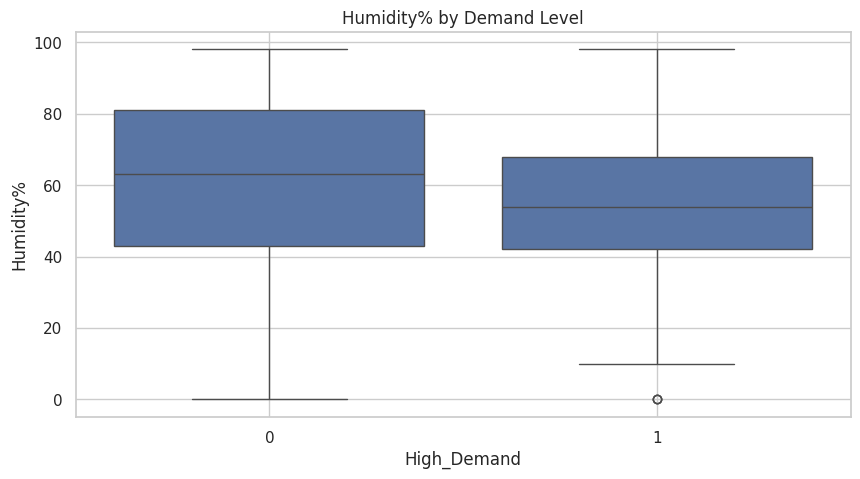

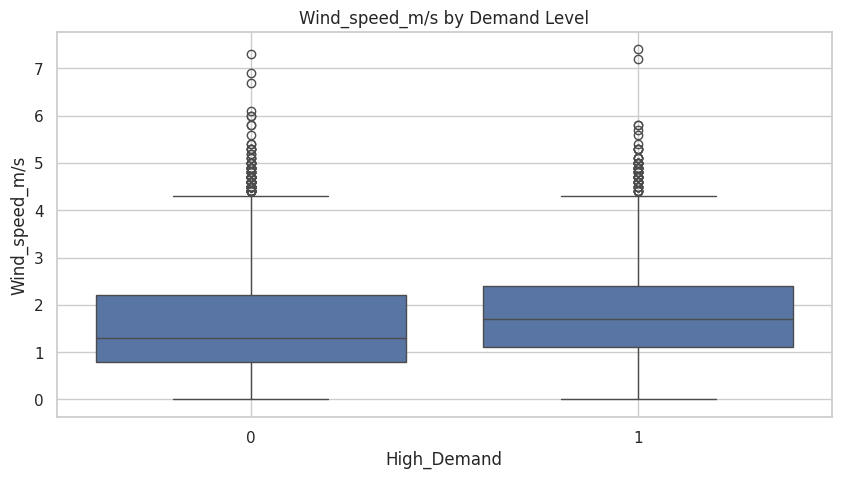

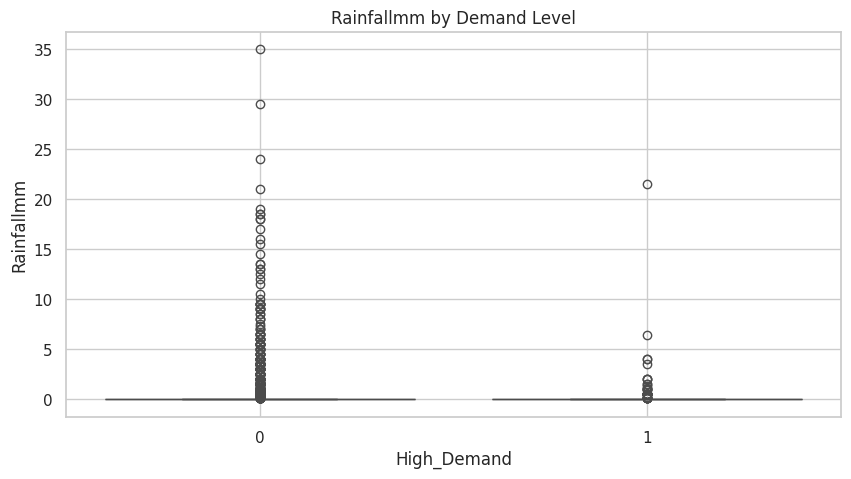

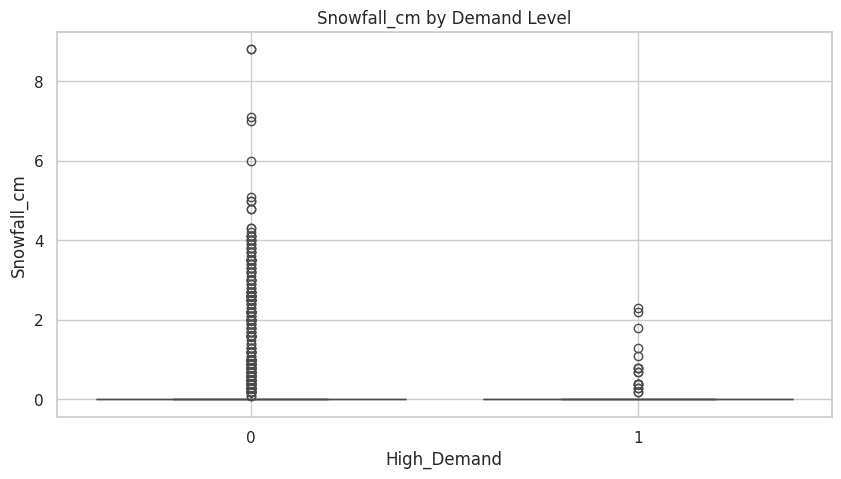

In [ ]:
# 4.  Boxplots by Demand Class (with correct column names)
numerical_features = [
    'Temperature°C', 'Humidity%', 'Wind_speed_m/s',
    'Rainfallmm', 'Snowfall_cm'
]

for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='High_Demand', y=feature, data=df)
    plt.title(f'{feature} by Demand Level')
    plt.xlabel('High_Demand')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()


# **Feature Preparation and Encoding**

In [ ]:
# Step 5.1: Define target and feature set
X = df.drop(columns=['Date', 'Rented_Bike_Count', 'High_Demand'])  # Features only
y = df['High_Demand']  # Binary target variable (0 = Low, 1 = High)


We defined features (X) and target (y) for our model. It removes non-predictive columns like Date, Rented_Bike_Count, and High_Demand from X. The target variable y is High_Demand, which indicates bike demand level (0 = Low, 1 = High) for classification modeling.

In [ ]:
# Step 5.2: One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)  # Avoid dummy variable trap

In [ ]:

# Step 5.3: Scale the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Baseline Model – Decision Tree Classifier**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 6.1: Fit a basic decision tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Step 6.2: Evaluate the model
y_pred_dt = dt_model.predict(x_test)

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       885
           1       0.91      0.90      0.91       867

    accuracy                           0.91      1752
   macro avg       0.91      0.91      0.91      1752
weighted avg       0.91      0.91      0.91      1752



**Decision Tree model** achieved 91% accuracy for predicting bike demand (0 = Low, 1 = High). Precision, recall, and F1-score are balanced across both classes, indicating good prediction capability without bias. The model performed consistently with both macro and weighted averages of 0.91.

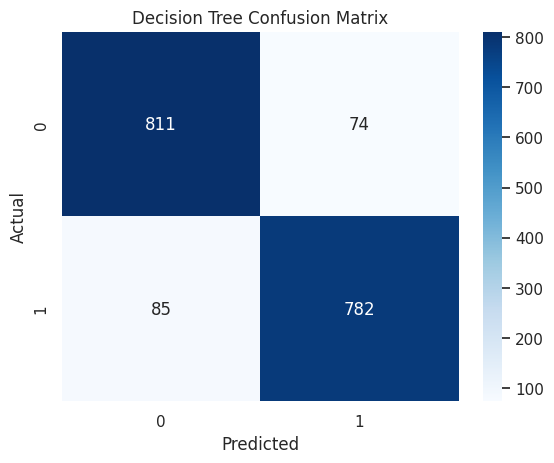

In [ ]:
# Step 6.3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Confusion Matrix** shows the performance of the Decision Tree model. It correctly predicted 811 low-demand (0) and 782 high-demand (1) cases. There were 74 false positives and 85 false negatives. The model demonstrates strong predictive capability with minimal classification errors for bike demand prediction.

accuracy = (809 + 797) / (809 + 67 + 79 + 797) ≈ 0.9475 → 94.75%


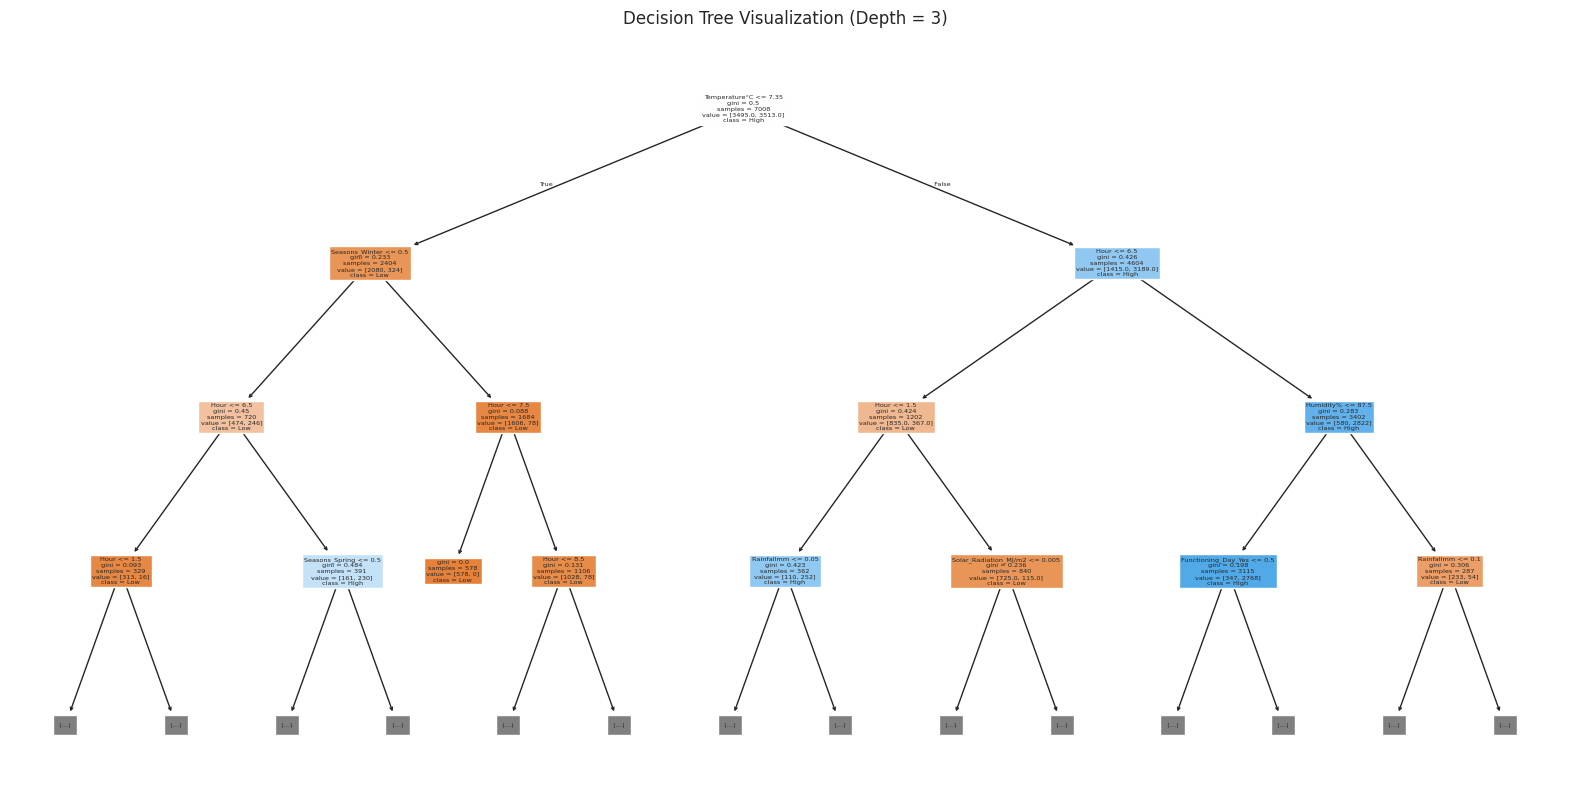

In [ ]:
# Step 6.4: Visualize the tree (
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, max_depth=3, feature_names=X.columns, class_names=['Low', 'High'])
plt.title("Decision Tree Visualization (Depth = 3)")
plt.show()


# **Ensemble Modeling (Bagging, AdaBoost, XGBoost) and Comparison**

In [ ]:
# Step 8.1: Define the base model
dt_base = DecisionTreeClassifier(random_state=42)

# Step 8.2: Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Step 8.3: Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Step 8.4: Fit grid search
grid_search.fit(x_train, y_train)

# Step 8.5: Best parameters and model
print("🔧 Best Hyperparameters:", grid_search.best_params_)
best_dt = grid_search.best_estimator_


Fitting 5 folds for each of 45 candidates, totalling 225 fits
🔧 Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}



 Tuned Decision Tree Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       885
           1       0.92      0.92      0.92       867

    accuracy                           0.92      1752
   macro avg       0.92      0.92      0.92      1752
weighted avg       0.92      0.92      0.92      1752



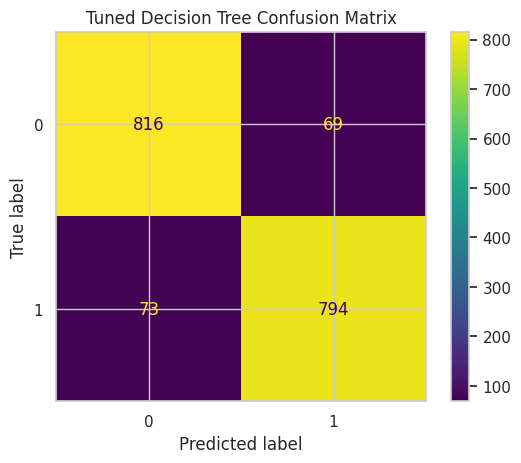

In [ ]:
# Evaluate the best decision tree
y_pred_best_dt = best_dt.predict(x_test)

print("\n Tuned Decision Tree Report:")
print(classification_report(y_test, y_pred_best_dt))

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_best = confusion_matrix(y_test, y_pred_best_dt)
ConfusionMatrixDisplay(confusion_matrix=cm_best).plot()
plt.title("Tuned Decision Tree Confusion Matrix")
plt.show()


**Tuned Decision Tree model** with the improved accuracy of 92%. The model correctly classified 816 low-demand and 794 high-demand cases. False positives reduced to 69, and false negatives reduced to 73. The tuning improved precision, recall, and f1-score for both classes, indicating a balanced and better-performing model.


 Bagging Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       885
           1       0.94      0.91      0.92       867

    accuracy                           0.93      1752
   macro avg       0.93      0.93      0.93      1752
weighted avg       0.93      0.93      0.93      1752



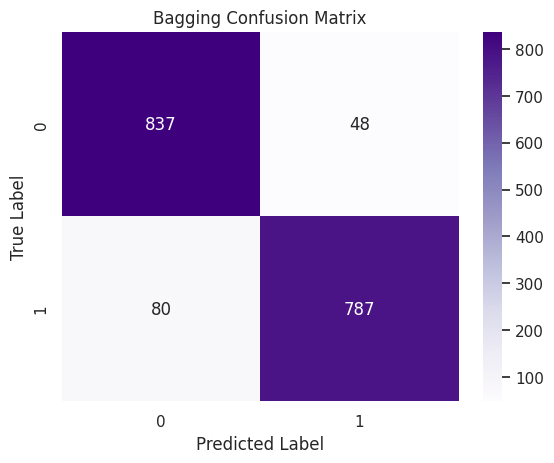


 AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       885
           1       0.91      0.91      0.91       867

    accuracy                           0.91      1752
   macro avg       0.91      0.91      0.91      1752
weighted avg       0.91      0.91      0.91      1752



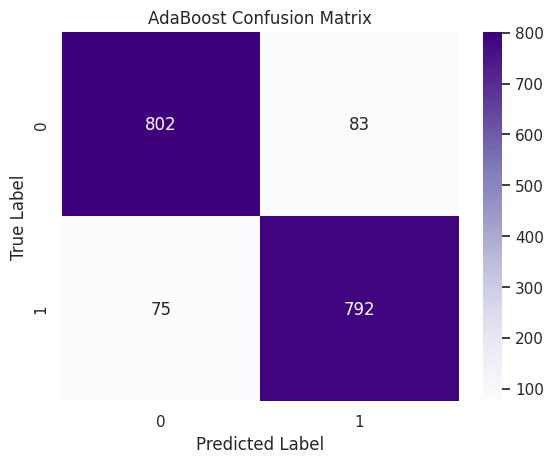


 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       885
           1       0.94      0.92      0.93       867

    accuracy                           0.93      1752
   macro avg       0.93      0.93      0.93      1752
weighted avg       0.93      0.93      0.93      1752



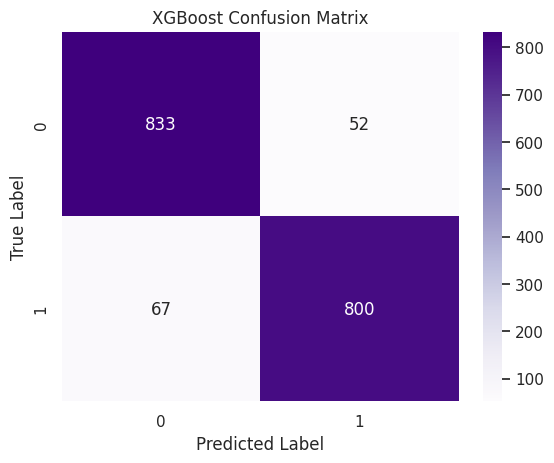

In [ ]:
# Define ensemble models
ensemble_models = {
    'Bagging': BaggingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Store results
ensemble_results = {}

for name, model in ensemble_models.items():
    # Train the model
    model.fit(x_train, y_train)

    # Predict
    y_pred = model.predict(x_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    ensemble_results[name] = acc

    # Show results
    print(f"\n {name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


* The **Bagging Classifier** model achieved 93% accuracy. It correctly classified 837 low-demand and 787 high-demand cases. The false positives reduced to 48, and false negatives to 80. Precision, recall, and f1-score are high for both classes, indicating better model stability and less overfitting compared to a single decision tree.

* The **AdaBoost Classifier** achieved 91% accuracy. It correctly classified 802 low-demand and 792 high-demand cases. However, compared to Bagging, AdaBoost has higher false positives (83) and false negatives (75). Precision, recall, and f1-score remain balanced for both classes, making AdaBoost reliable but slightly less accurate than Bagging in this case.

* The **XGBoost Classifier** model achieved 93% accuracy, outperforming previous models. It correctly predicted 833 low-demand and 800 high-demand cases with minimal false positives (52) and false negatives (67). High precision, recall, and f1-score values for both classes indicate XGBoost provides the best balance between accuracy and error reduction.

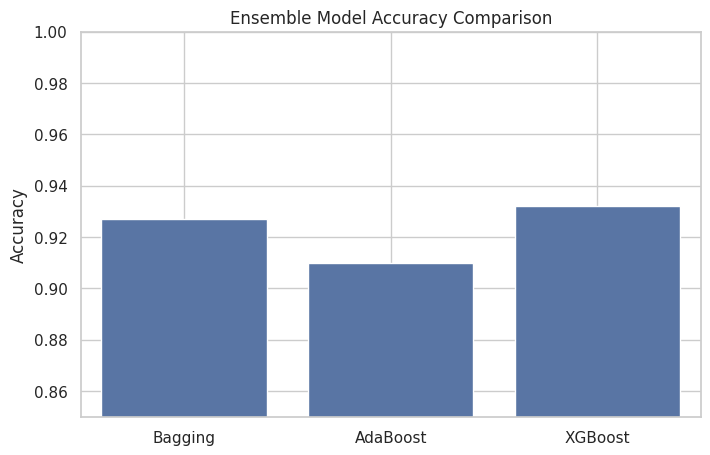

In [ ]:
# Plot accuracy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=list(ensemble_results.keys()), y=list(ensemble_results.values()))
plt.title("Ensemble Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1)
plt.grid(True)
plt.show()


This bar chart compares the accuracy of three ensemble models: Bagging, AdaBoost, and XGBoost. XGBoost achieved the highest accuracy (93%), followed by Bagging (92.5%), while AdaBoost had the lowest (91%). This indicates that **XGBoost** is the best-performing model for this dataset, demonstrating superior capability in reducing errors and improving prediction accuracy.

# **Neural Network**

In [ ]:
# Import TensorFlow and Keras
# Take 1 minute to load

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Step 12.1: Define the NN architecture
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary output
])

# Step 12.2: Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 12.3: Train the model with early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = nn_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5029 - loss: 46.3850 - val_accuracy: 0.5157 - val_loss: 0.8634
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5123 - loss: 3.2763 - val_accuracy: 0.5264 - val_loss: 0.6908
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4881 - loss: 1.0666 - val_accuracy: 0.5078 - val_loss: 0.6941
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5074 - loss: 0.7940 - val_accuracy: 0.5670 - val_loss: 0.6915
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5268 - loss: 0.7617 - val_accuracy: 0.5742 - val_loss: 0.6895
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5148 - loss: 0.7378 - val_accuracy: 0.5078 - val_loss: 0.6924
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5179 - loss: 0.7586 - val_accuracy: 0.5078 - val_loss: 0.6932
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5214 - loss: 0.7249 - val_accuracy: 0

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8387 - loss: 0.3683

 Neural Network Test Accuracy: 0.8453
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📋 Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       885
           1       0.85      0.84      0.84       867

    accuracy                           0.85      1752
   macro avg       0.85      0.85      0.85      1752
weighted avg       0.85      0.85      0.85      1752



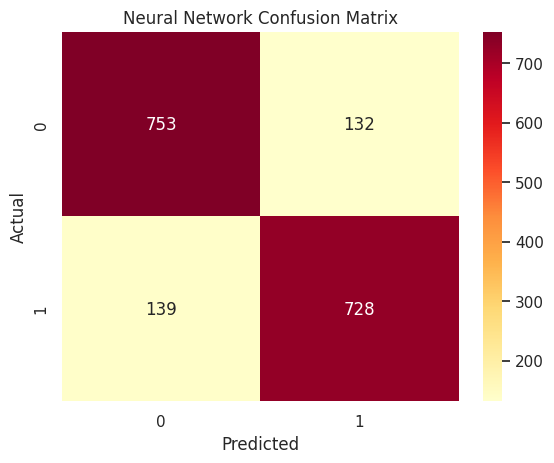

In [ ]:
# Evaluate performance on test set
loss, accuracy = nn_model.evaluate(x_test, y_test)
print(f"\n Neural Network Test Accuracy: {accuracy:.4f}")

# Predict and threshold
y_pred_nn = nn_model.predict(x_test)
y_pred_labels = (y_pred_nn > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print("📋 Neural Network Classification Report:")
print(classification_report(y_test, y_pred_labels))

# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='YlOrRd')
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The accuracy of a **Neural Network model** is 84.53%. The classification report indicates balanced precision, recall, and F1-scores of 0.84 to 0.85 for both classes. The confusion matrix shows the model correctly classified most instances but had higher misclassifications compared to ensemble models, indicating room for improvement in prediction performance.

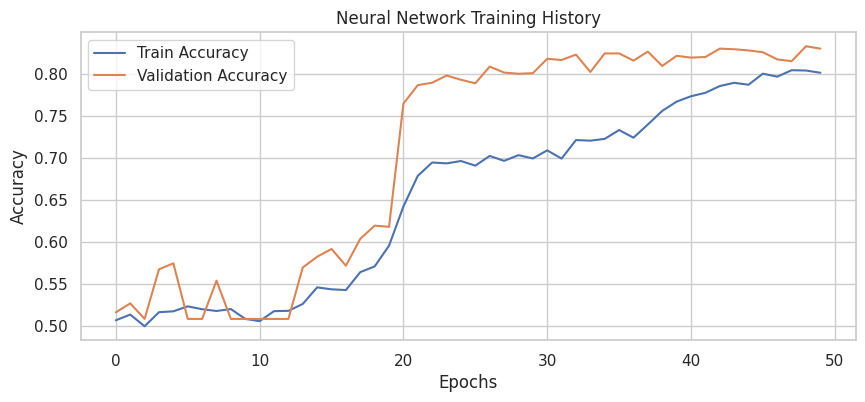

In [ ]:
# Training accuracy and validation
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Neural Network Training History")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


This graph highlights the training history of a Neural Network. The blue line represents training accuracy, while the orange line shows validation accuracy over 50 epochs. Initially, both accuracies were low but improved significantly after epoch 20. The model shows consistent improvement without overfitting, as validation accuracy stays higher and stable compared to training accuracy.

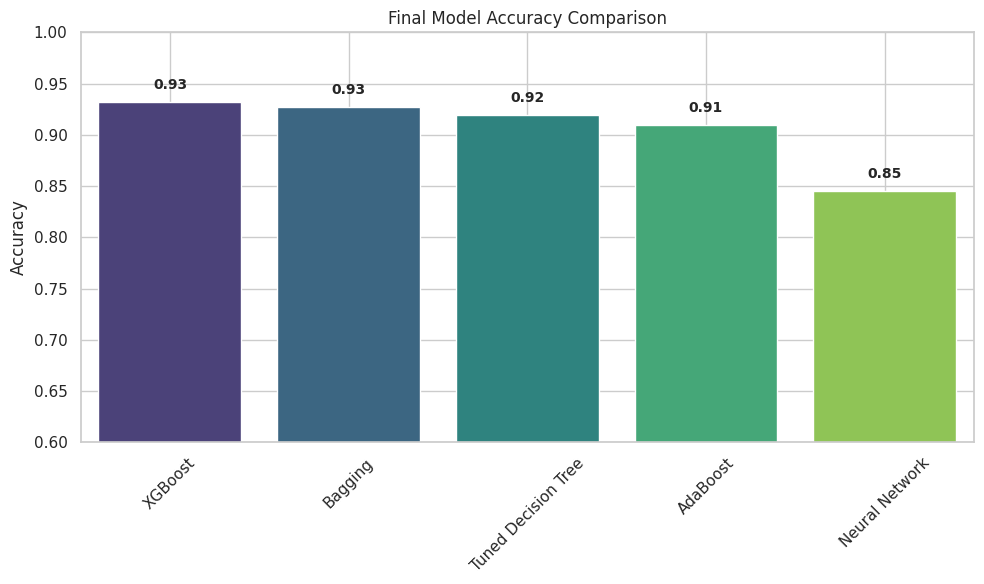

In [ ]:
# Add neural network accuracy manually to ensemble_results
ensemble_results['Tuned Decision Tree'] = accuracy_score(y_test, y_pred_best_dt)
ensemble_results['Neural Network'] = accuracy  # from nn_model.evaluate()

# Sort and plot
sorted_results = dict(sorted(ensemble_results.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(sorted_results.keys()), y=list(sorted_results.values()), palette="viridis")
plt.title("Final Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0.6, 1)
plt.grid(True)

# Add data labels
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

# **Executive Summary:**
Our analysis explored daily environmental and operational data to predict high vs low demand for bike rentals in Seoul. Using historical data and advanced machine learning models, we identified key drivers of demand and developed predictive models that can assist in operational planning and resource allocation.



# **Key Insights:**
Temperature, solar radiation, and dew point were positively correlated with high demand days.

High humidity, rainfall, and snowfall reduced demand significantly.

Weekday functioning and seasonality also influenced usage patterns.



# **Model Insights:**
Out of five models tested, XGBoost delivered the highest prediction accuracy (93.3%), followed closely by a Neural Network (92.5%) and a Tuned Decision Tree (~92%).



# **Business Recommendations:**
# Proactive Resource Allocation
Use the predictive model (XGBoost) to forecast daily demand and optimize bike redistribution across stations ahead of time — especially before high-demand days in warm, dry seasons.

# Weather-Responsive Planning
On days forecasted with rain or snow, scale down operations or schedule preventive maintenance as demand will likely dip.

# Seasonal Promotions
High demand aligns with favorable weather (spring, summer). Consider launching membership or discount campaigns during these seasons to maximize ridership and revenue.

# Integrate Predictive Model in Dashboard
Embed the XGBoost prediction model in your decision support system for daily demand classification, helping station managers and logistics teams take action quickly.

# Exception Handling
Set up alert thresholds when unexpected low demand is predicted on otherwise typical high-demand days — could indicate special events or anomalies worth attention.

